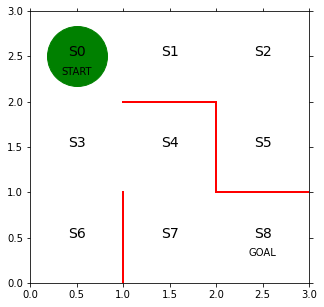

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from matplotlib import cm
import random

fig = plt.figure(figsize=(5,5))
ax = plt.gca()
"""
可视化用的，不影响数学建模
"""
plt.plot([1,1],[0,1],color='red',linewidth = 2)
plt.plot([1,2],[2,2],color='red',linewidth = 2)
plt.plot([2,2],[2,1],color='red',linewidth = 2)
plt.plot([2,3],[1,1],color='red',linewidth = 2)

plt.text(0.5,2.5,'S0',size=14,ha='center')
plt.text(1.5,2.5,'S1',size=14,ha='center')
plt.text(2.5,2.5,'S2',size=14,ha='center')
plt.text(0.5,1.5,'S3',size=14,ha='center')
plt.text(1.5,1.5,'S4',size=14,ha='center')
plt.text(2.5,1.5,'S5',size=14,ha='center')
plt.text(0.5,0.5,'S6',size=14,ha='center')
plt.text(1.5,0.5,'S7',size=14,ha='center')
plt.text(2.5,0.5,'S8',size=14,ha='center')

plt.text(0.5,2.3,'START',ha='center')
plt.text(2.5,0.3,'GOAL',ha ='center')

ax.set_xlim(0,3)
ax.set_ylim(0,3)
plt.tick_params(axis = 'both',which='both',bottom = 'off',top = 'off',
               labelbottom = 'off',right = 'off',left='off',labelleft = 'off')
line, = ax.plot(0.5,2.5,marker='o',color = 'g',markersize = 60)     #  移动object

In [12]:
theta_0 = np.array(
    [[np.nan,1,1,np.nan],             #方案，用于转换为概率的值
    [np.nan,1,np.nan,1],
    [np.nan,np.nan,1,1],
    [1,1,1,np.nan],
    [np.nan,np.nan,1,1],
    [1,np.nan,np.nan,np.nan],
    [1,np.nan,np.nan,np.nan],
    [1,1,np.nan,np.nan]])

"""θ中包含状态和选择"""

def simple_convert_into_pi_from_theta(theta):   
    """
返回策略集合PI，各个状态的各个选择的概率，直接转换,既每一步策略随机选择，且大小不变，
    """
    beta = 0.1                           #   
    [m,n] = theta.shape
    pi = np.zeros((m,n))

    exp_theta = np.exp(beta * theta)   #e^(β*θ)
    for i in range(m):
        pi[i,:] = exp_theta[i,:]/np.nansum(exp_theta[i,:])
    pi = np.nan_to_num(pi)        #   矩阵中的空值转换为数字0
    
    return pi

pi_0 = simple_convert_into_pi_from_theta(theta_0)

In [3]:
def get_next_s(pi,s): #随机策略到达下一个状态

    """
    pi策略
    s状态
    """
    direction = ['up','right','down','left']

    next_direction = np.random.choice(direction,p = pi[s,:])       #随机选择

    if next_direction == 'up':
        action = 0                                       #   a
        s_next = s-3                                     #   s'
    elif next_direction == 'right':                                         
        action = 1                                       #   a
        s_next = s+1                                     #   s'
    elif next_direction == 'down':
        action = 2                                       #   a
        s_next = s+3                                     #   s'
    elif next_direction == 'left':
        action = 3                                       #   a
        s_next = s-1                                     #   s'

    return action,s_next                            # 返回当前动作和状态



def goal_maze_ret_s_a(pi):
    """
     返回轨迹，和动作
    """
    s = 0
    s_a_history = [[0,np.nan]]

    while(1):
        action,next_s = get_next_s(pi,s)
        s_a_history[-1][1] = action       
        s_a_history.append([next_s,np.nan])
        if next_s == 8:
            break
        else:
            s = next_s

    return s_a_history



In [14]:
# pi_0 是选择集合，[0,0,0.5,0.5]每个状态的各个策略以及概率
# action 动作分类，以数值区分，1234
# s状态，共九个状态0~8
# get_next_s返回动作和动作后状态组成的list

def init():
    line.set_data([],[])
    return (line,)

def animate(i):
    state = s_a_history[1][i]
    x = (state % 3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data(x,y)
    return (line,)

anim = animation.FuncAnimation(fig,animate,init_func = init,frames=len(s_a_history[0]),interval = 200,repeat=False)

HTML(anim.to_jshtml())

# 更新策略

In [26]:
def softmax_convert_into_pi_from_theta(theta):
    """pi(Θ)"""
    beta = 1.0
    [m,n] = theta.shape
    pi = np.zeros((m,n))
    
    exp_theta = np.exp(beta *theta)
    for i in range(0,m):
        pi[i,:]=exp_theta[i,:]/np.nansum(exp_theta[i,:])
    pi = np.nan_to_num(pi)
    return pi

def update_theta(theta, pi, s_a_history):
    """
    更新策略需要状态(s)和动作(a)的日志（或者说轨迹,历史）
    Π(theta)中theta的形状，策略参数集合的形状，m等于状态集合的维度，n等于action集合的维度策略

    """
    eta = 0.2
    T = len(s_a_history) - 1

    [m, n] = theta.shape
    delta_theta = theta.copy()
    direction = ['up','right','down','left']
    """
    SA list of state and action,SA[0] is a state,0状态时的动作集合
    """
    for i in range(m):           #  状态维度m
        """

        """
        SA_i = [SA for SA in s_a_history if SA[0] == i]  # 状态为i时的SA集合,状态相同，动作不同
        N_i = len(SA_i)  # 状态i的集合大小

        for j in range(n):      #动作维度n
            SA_ij = [SA for SA in s_a_history if SA == [i, j]]
            """
            状态为i，动作为j的集合，SA_ij中所有元素相同
            """
            N_ij = len(SA_ij)
            
            delta_theta[i, j] = (N_ij-pi[i, j]*N_i)/T      # Δθ的更新量
            if i == 4:
                print("总步数:\t",T,"4状态下动作总数：\t",N_i,"状态4时选择{}的次数：\t".format(direction[j]),N_ij)

    new_theta=theta+eta*delta_theta
    
    return new_theta

In [152]:
pi = pi_0
theta = theta_0

In [448]:
s_a_history = goal_maze_ret_s_a(pi)
new_theta = update_theta(theta,pi,s_a_history)
new_pi = softmax_convert_into_pi_from_theta(new_theta)

print(new_pi)

theta = new_theta
pi = new_pi

总步数:	 6 4状态下动作总数：	 1 状态4时选择up的次数：	 0
总步数:	 6 4状态下动作总数：	 1 状态4时选择right的次数：	 0
总步数:	 6 4状态下动作总数：	 1 状态4时选择down的次数：	 1
总步数:	 6 4状态下动作总数：	 1 状态4时选择left的次数：	 0
[[0.         0.15513459 0.84486541 0.        ]
 [0.         0.33909809 0.         0.66090191]
 [0.         0.         0.46189353 0.53810647]
 [0.08084384 0.80287181 0.11628435 0.        ]
 [0.         0.         0.88147692 0.11852308]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.13205745 0.86794255 0.         0.        ]]


In [4]:
"""
print状态为i时的选择
"""
s_a_history = s_a_history = goal_maze_ret_s_a(pi_0)
print('求解迷宫所需的步数：'+str(len(s_a_history)-1))
eta = 0.2
T = len(s_a_history) - 1
delta_theta = theta_0.copy()
# for i in range(8):
i = 4
SA_i = [SA for SA in s_a_history if SA[0] == i]  # 状态为i时的SA集合,状态相同，动作不同
N_i = len(SA_i)  # 状态i的集合大小
pi = softmax_convert_into_pi_from_theta(new_theta)
new_theta = update_theta(new_theta,pi,s_a_history)
print(SA_i)
print(new_theta)


求解迷宫所需的步数：36
[[4, 3], [4, 3], [4, 2], [4, 2], [4, 2]]


In [8]:
s_a_history = goal_maze_ret_s_a(pi)
# print(s_a_history)
print('求解迷宫所需的步数：'+str(len(s_a_history)-1))     
theta = update_theta(theta,pi,s_a_history)   #  根据state,action更新policy参数

pi = softmax_convert_into_pi_from_theta(theta)
print(pi)

NameError: name 'pi' is not defined

In [7]:
stop_eplilon = 10**-4

theta = theta_0
pi = pi_0

is_continue = True
while is_continue:
    s_a_history = goal_maze_ret_s_a(pi)
    new_theta = update_theta(theta,pi,s_a_history)
    new_pi = softmax_convert_into_pi_from_theta(new_theta)
    
    print(np.sum(np.abs(new_pi-pi)))
    
    if np.sum(np.abs(new_pi-pi)) <stop_eplilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi



0.041050130075866775
0.02069428543801377
0.01552618801363953
0.06110760062539827
0.04750206993840195
0.05244858796264584
0.016766217407772677
0.01612420194377645
0.02431396253428969
0.010356745653149091
0.04235119814708693
0.05033690501961513
0.03850188938947974
0.02819304271049955
0.024943740744595766
0.017981993219580328
0.011978339489180312
0.019562879296947555
0.04696298334006138
0.016837824523122324
0.012271669276057329
0.031230519844870464
0.03961643568821788
0.020341937727444304
0.06237417665130357
0.012515558213082534
0.044561750923074295
0.057528833152230785
0.014082744650424528
0.07323973376394988
0.031536775315850696
0.030524148642640192
0.027475063874933092
0.02727489710357739
0.033888100101875984
0.026958337598968374
0.02371192405160405
0.03049464654509232
0.0266615261447965
0.021368675225533762
0.04393865659296964
0.0286187082587393
0.02045119582980065
0.03143316969922483
0.05495127682432199
0.05650884467952488
0.062281846386869344
0.028282121780636105
0.09111430309831359

In [4]:
"""

theta   策略参数
pi：策略
策略更新函数
价值函数
将action和下一个s+1状态拆成两个函数
"""

def get_action(s, Q, epsilon, pi_0):   #有一定概率选择最大动作价值行动，返回action
     """
     s是当前状态
     np.nanargmax[]返回[]内最大值的索引
     """
    direction = ['up', 'right', 'down', 'left']
    next_direction = np.random.choice(direction,p = pi_0[s,:])       #随机选择
    if np.random.rand() < epsilon:
        next_direction = np.random.choice(direction,p = pi_0[s,:])
    else:
        next_direction = direction[np.nanargmax(Q[s,:])]

    if next_direction == 'up':
        action = 0                                       #   a
    elif next_direction == 'right':
        action = 1                                       #   a
    elif next_direction == 'down':
        action = 2                                       #   a
    elif next_direction == 'left':
        action = 3                                       #   a
    return action

def get_s_next(s,a):                 #返回动作a后的状态
    # a = get_action()
    direction = ['up','right','down','left']
    next_direction = direction[a]

    if next_direction == 'up':
        s_next = s-3                                     #   s'
    elif next_direction == 'right':
        s_next = s+1                                     #   s'
    elif next_direction == 'down':
        s_next = s+3                                     #   s'
    elif next_direction == 'left':
        s_next = s-1                                     #   s'

    return s_next

def Sarsa(s,a,r,s_next,a_next,eta,gamma,Q):              #价值Q更新，迭代函数
    """
    eta:
    gamma:
    """
    if s_next == 8:
        Q[s,a] = Q[s,a] + eta*(r-Q[s,a])
    else:
        Q[s,a] = Q[s,a]+eta*(r+gamma*np.nanmax(Q[s_next,:])-Q[s,a])    #Q学习
#          Q[s,a] = Q[s,a]+eta*(r+gamma*Q[s_next,a_next]-Q[s,a])        #Sarsa
    return Q
                             
        
def goal_maze_ret_s_a_Q(Q,epsilon,eta,gamma,pi):     #返回路径和价值
    s = 2
    a = a_next = get_action(s,Q,epsilon,pi)
    s_a_history  = [[2,np.nan]]
    
    while (1):
        a = a_next
        s_a_history[-1][1] = a
        s_next = get_s_next(s,a)
        s_a_history.append([s_next,np.nan])
        if s_next == 8:
            r = 1
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next,Q,epsilon,pi)
        Q = Sarsa(s,a,r,s_next,a_next,eta,gamma,Q)    
        
        if s_next == 8:
            break
        else:
            s = s_next
    return [s_a_history,Q]

In [449]:
"""随机初始价值函数"""
a,b = theta_0.shape

Q = np.random.rand(a,b)*theta_0*0.1  #价值函数集合，是一个矩阵
print(Q)

[[       nan 0.05124374 0.08129662        nan]
 [       nan 0.01696105        nan 0.05919157]
 [       nan        nan 0.03264734 0.05460402]
 [0.06229061 0.02078699 0.07559611        nan]
 [       nan        nan 0.05885197 0.07388989]
 [0.02375393        nan        nan        nan]
 [0.08010784        nan        nan        nan]
 [0.07352982 0.02785242        nan        nan]]


In [97]:
epsilon = epsilon/2
s_a_history,Q = goal_maze_ret_s_a_Q(Q,epsilon,0.3,0.1,pi_0)

print(s_a_history)
print(pd.DataFrame(Q,columns=['up', 'right', 'down', 'left']))

[[2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 3], [0, 2], [3, 1], [4, 2], [7, 0], [4, 2], [7, 1], [8, nan]]
         up     right      down      left
0       NaN  0.052129  0.068965       NaN
1       NaN  0.015476       NaN  0.050333
2       NaN       NaN  0.011945  0.013318
3  0.029138  0.052699  0.036571       NaN
4       NaN       NaN  0.019564  0.007767
5  0.008797       NaN       NaN       NaN
6  0.017097       NaN       NaN       NaN
7  0.051128  0.342775       NaN       NaN


In [151]:
"""
v某回合每个状态Q的最大值
V，v的集合
"""
v=np.nanmax(Q,axis=1)
is_continue = True
episode = 1
V=[]
V.append(np.nanmax(Q,axis=1))

while is_continue:
    print("回合数："+str(episode))
    epsilon = epsilon/2
    s_a_history,Q = goal_maze_ret_s_a_Q(Q,epsilon,0.3,0.1,pi_0)
    new_v = np.nanmax(Q,axis=1)
    print(np.sum(np.abs(new_v-v)))
    v=new_v
    V.append(v)
    print("求解迷宫为题所需的步数是："+str(len(s_a_history)-1))
    episode = episode + 1
    if episode > 100:
        break

NameError: name 'Q' is not defined

In [99]:
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)
    def animate(i):
        line, = ax.plot([0.5],[2.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
        line, = ax.plot([1.5],[2.5],marker='s',color=cm.jet(V[i][1]),markersize=85)
        line, = ax.plot([2.5],[2.5],marker='s',color=cm.jet(V[i][2]),markersize=85)
        line, = ax.plot([0.5],[1.5],marker='s',color=cm.jet(V[i][3]),markersize=85)
        line, = ax.plot([1.5],[1.5],marker='s',color=cm.jet(V[i][4]),markersize=85)
        line, = ax.plot([2.5],[1.5],marker='s',color=cm.jet(V[i][5]),markersize=85)
        line, = ax.plot([0.5],[0.5],marker='s',color=cm.jet(V[i][6]),markersize=85)
        line, = ax.plot([1.5],[0.5],marker='s',color=cm.jet(V[i][7]),markersize=85)
        line, = ax.plot([2.5],[0.5],marker='s',color=cm.jet(1.0),markersize=85)

        return (line,)

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=len(V),interval=200,repeat=False)

HTML(anim.to_jshtml())

In [ ]:
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)
def animate(i):
    line, = ax.plot([0.5],[2.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([1.5],[2.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([2.5],[2.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([0.5],[1.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([1.5],[1.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([2.5],[1.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([0.5],[0.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([1.5],[0.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([2.5],[0.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    
    return (line,)

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=len(V),interval=200,repeat=False)

HTML(anim.to_jshtml())

In [ ]:
epsilon = 0.5
s_a_history,Q = goal_maze_ret_s_a_Q(Q,epsilon,0.3,0.1,pi_0)

In [18]:
print("hello\t","world\n","fuck\t","world\n")

hello	 world
 fuck	 world

